In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

In [12]:
# Load data using pandas
data_sample = pd.read_csv('data.csv', header=None).to_numpy()
print(data_sample)

[[3.300750e+00 1.000000e+00]
 [1.579125e+00 5.000000e+02]
 [8.600000e-01 1.000000e+03]
 [7.425000e-01 1.500000e+03]
 [5.565000e-01 2.000000e+03]
 [5.356250e-01 2.500000e+03]
 [4.143750e-01 3.000000e+03]
 [4.168750e-01 3.500000e+03]
 [3.903750e-01 4.000000e+03]
 [3.903750e-01 4.500000e+03]]


[778.72960407   1.72807995  28.57845897]
132.9175704153777
1470.9251313523016


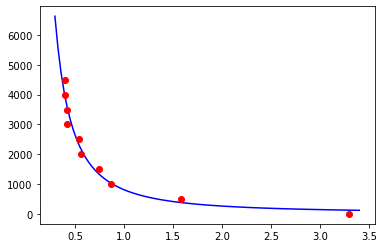

In [13]:



def func(x, a, b,c):
    return a/x**b + c

popt, pcov = curve_fit(func, data_sample[:,0], data_sample[:,1])
print(popt)

x = np.linspace(np.min(data_sample[:,0])-0.1, np.max(data_sample[:,0] + 0.1), 100)
print(func(3.2,*popt))
print(func(0.7,*popt))
#plt.yscale('log')
plt.plot(x, func(x, *popt), 'b-')
plt.plot(data_sample[:,0], data_sample[:,1], 'ro')

In [14]:
params = [0.97348234
1.27729453
-1.69600371]

plt.plot(x, func(x, *params), 'b-')
plt.plot(data_sample[:,0], data_sample[:,1], 'ro')

SyntaxError: invalid syntax (<ipython-input-14-746f9eb8b349>, line 2)

[ 5.70645626  0.70927315 -3.99784116]


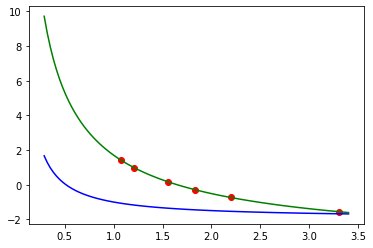

In [16]:
params = [0.9295698,1.093334,-1.923782]

arr = np.array([
    [3.30, -1.56],
[2.20, -0.71],
[1.83, -0.28],
[1.56, 0.14],
[1.21, 0.99],
[1.08, 1.41],
])

plt.plot(arr[:,0], arr[:,1], 'ro')
plt.plot(x, func(x, *params), 'b-')
popt, pcov = curve_fit(func, arr[:,0], arr[:,1])
print(popt)
plt.plot(x, func(x, *popt), 'g-')

